# **Example**: Hiera Inference (Image)

Requires `hiera-transformer`, `timm`, `pillow`, and `torchvision` to be installed.

In [1]:
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import hiera
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [2]:
# Load a base model
model = hiera.hiera_base_224(pretrained=True, checkpoint="mae_in1k_ft_in1k")  # Checkpoint is optional (will use default)

In [3]:
# Create input transformations
input_size = 224

transform_list = [
    transforms.Resize(int((256 / 224) * input_size), interpolation=InterpolationMode.BICUBIC),
    transforms.CenterCrop(input_size)
]

# The visualization and model need different transforms
transform_vis  = transforms.Compose(transform_list)
transform_norm = transforms.Compose(transform_list + [
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

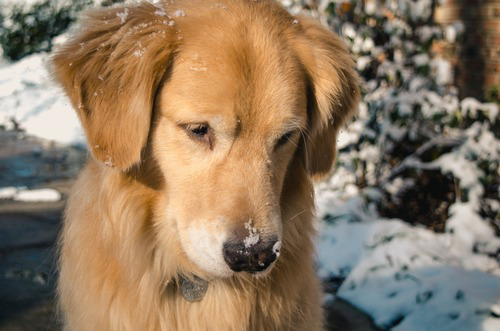

In [4]:
# Load the image
img = Image.open("./img/dog.jpg")
img_vis = transform_vis(img)
img_norm = transform_norm(img)

img  # sadboye

## Running the model

In [5]:
# Get imagenet class as output
out = model(img_norm[None, ...])

# 207: golden retriever  (imagenet-1k)
out.argmax(dim=-1).item()

207

In [6]:
# If you also want intermediate feature maps
_, intermediates = model(img_norm[None, ...], return_intermediates=True)

for x in intermediates:
    print(x.shape)

torch.Size([1, 56, 56, 96])
torch.Size([1, 28, 28, 192])
torch.Size([1, 14, 14, 384])
torch.Size([1, 7, 7, 768])


# **Example**: Hiera Inference (Video)

Requires `hiera-transformer`, `av`, `matplotlib`, and `torchvision` to be installed.

**Note**: This is for demonstration purposes only. The actual dataloader we used for training and evaluation on Kinetics is in [SlowFast](https://github.com/facebookresearch/SlowFast/blob/main/slowfast/datasets/kinetics.py).  
We sample 16 frames, with 4 temporal stride on Kinetics (30 fps video). Thus we sample roughly one frame every 133 ms.  
Do note however that video sampling is a complex process and this information might not be a 100% accurate, so _please use the SlowFast dataloader in practice._

In [7]:
from torchvision.io import read_video
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch, hiera

30.0


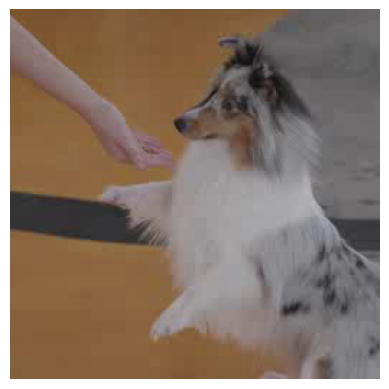

In [8]:
# I used the following command to sample these videos:
#   ffmpeg -i vid.mp4 -vf "crop=w=min(iw\,ih):h=min(iw\,ih),scale=256:256,fps=fps=30" -ss 00:00:00 -t 00:00:05 output.mp4
vid_path = "./vid/dog.mp4"  # Also try "goat.mp4"!

# Load the frames
frames, audio, info = read_video(vid_path, pts_unit='sec', output_format='THWC')
frames = frames.float() / 255  # Convert from byte to float
print(info['video_fps'])  # Should be 30

plt.figure(frameon=False)
plt.imshow(frames[72].numpy())  # Frame 72 of the video
plt.axis("off")
plt.show()  # compressedboye

In [9]:
# Sample 16 frames with 4 temporal stride: 64 frames per clip, but take every 4th frame
# During testing, we sample 5 clips uniformly in time (and 3 in space) and avg the results
# This is important because videos can be long with an action any point in the video
# Let's just do 2 for demo purposes
frames = torch.stack([frames[:64], frames[64:128]], dim=0)
frames = frames[:, ::4]  # Sample every 4 frames
frames.shape


torch.Size([2, 16, 256, 256, 3])

In [10]:
# Interpolate the frames to 224 and put channels first
frames = frames.permute(0, 4, 1, 2, 3).contiguous()
frames = F.interpolate(frames, size=(16, 224, 224), mode="trilinear")
frames.shape

torch.Size([2, 3, 16, 224, 224])

In [11]:
# Normalize the clip
frames = frames - torch.tensor([0.45, 0.45, 0.45]).view(1, -1, 1, 1, 1)     # Subtract mean
frames = frames / torch.tensor([0.225, 0.225, 0.255]).view(1, -1, 1, 1, 1)  # Divide by std

## Running the model

In [12]:
# Load a base model
model = hiera.hiera_base_16x224(pretrained=True, checkpoint="mae_k400_ft_k400")  # Checkpoint is optional (will use default)

In [13]:
# Get kinetics classes as output
out = model(frames)

# Average results over the clips
out = out.mean(0)

# 363: training dog  (kinetics-400)
# 125: feeding goat  (kinetics-400)
out.argmax(dim=-1).item()

363